In [101]:
# common imports
import numpy as np
import pandas as pd
import os, cv2, joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.pipeline import Pipeline

# global variables
global ROWS, COLUMNS, CHANNELS
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.

# 1. Getting the Data

In [2]:
path = r"dogs-vs-cats\train/"

images = [path + i for i in os.listdir(path)]
# listdir returns a list with the file names in the given directory

In [3]:
def load_dogs_vs_cats(image_dir):
    images_lst = [image_dir + i for i in os.listdir(image_dir)]
    # listdir returns a list with the file names in the given directory
    y = []
    path = []
    for i, image_path in enumerate(images_lst):
        path.append(image_path)
        if '/dog' in image_path:
            y.append(1)
        elif '/cat' in image_path:
            y.append(0)
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y.append(image_path.split('/')[-1].split('.')[0])
    return pd.DataFrame({"path": path, "label": y})

In [4]:
df = load_dogs_vs_cats(path)

In [5]:
df.head()

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0
3,dogs-vs-cats\train/cat.100.jpg,0
4,dogs-vs-cats\train/cat.1000.jpg,0


In [6]:
df.isna().sum().sum()

0

In [7]:
df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [8]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [9]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3]
sample0

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0


In [10]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3]
sample1

,path,label
12500,dogs-vs-cats\train/dog.0.jpg,1
12501,dogs-vs-cats\train/dog.1.jpg,1
12502,dogs-vs-cats\train/dog.10.jpg,1


In [11]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

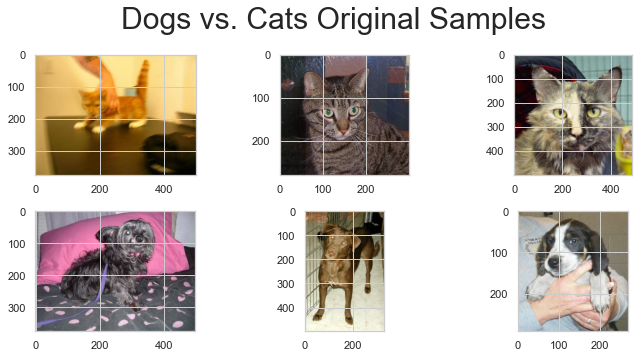

In [12]:
fig = plt.figure(figsize=(10, 7))

for i in range(len(sample_images)):
    plt.subplot(330 + i + 1)
    filename = sample_images['path'][i]
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.suptitle("Dogs vs. Cats Original Samples", size=30)
plt.tight_layout()
plt.show()

> Initial Observations:
>> * The dogs and cats are in different angles. Some are cropped in a way that only the face is seen,
>> others of the whole body.
>> * The photos may also include a person or surrounding objects (i.e. in the bottom right image the
> dog is held by a person).
>> The photos could also be blurry (i.e. in the top left photo it looks like the camera was slightly
>> moved while taking the photo).
>> * There are various image sizes.
>> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
>> * The images are in color, meaning the number of pixels chosen for the width and height will be multiplied by 3.
>> This should be taken into account since it adds a substantial amount of features, as opposing to using grayscale images.
>
> The following functions will read the data, and turn it into a DataFrame.
> When implementing these functions, I took into account that rescaling the images and loading new data could be needed
> further on. (Necessary tweaks implemented in the code according to these measures).
>
> Note: The default rescaled size of the images is 64x64x3. This will likely change later on.

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

The training and testing data should be representative of both classes.
I noticed that the number of samples for dogs and cats are equal and decided a stratified
split is the optimal choice.
Although regular random sampling would have split the data nearly equally, there would
have been more bias towards one of the classes.

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['label']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [14]:
strat_test_set['label'].value_counts() / len(strat_test_set)

1    0.5
0    0.5
Name: label, dtype: float64

In [15]:
# DataFrame shape (rows, columns)
print("Training Set:", strat_train_set.shape)
print("Test Set:", strat_test_set.shape)

Training Set: (20000, 2)
Test Set: (5000, 2)


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [16]:
# deep copy of the training set
df2 = strat_train_set.copy()

In [17]:
df2.head(2)

,path,label
20022,dogs-vs-cats\train/dog.5518.jpg,1
4993,dogs-vs-cats\train/cat.3241.jpg,0


In [18]:
def image_shape(image_path):
    return cv2.imread(image_path).shape


def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return shapes

In [19]:
# image_shapes = load_data_shapes(strat_train_set['path'])
# joblib.dump(image_shapes, "dogs-vs-cats/image_shapes.pkl")

In [20]:
image_shapes = joblib.load(r"dogs-vs-cats/image_shapes.pkl")

In [21]:
image_res_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels'])
image_res_df.head(3)

,height,width,n_channels
0,138,129,3
1,374,500,3
2,438,349,3


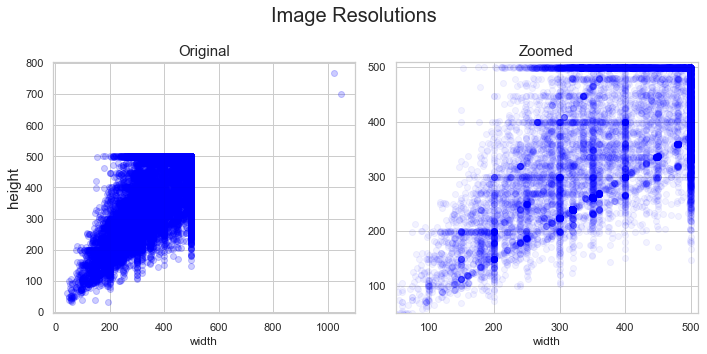

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.2)
ax1.set_title("Original", size=15)
points = ax2.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height", size=15)
ax2.set_xlim(xmin=50, xmax=510)
ax2.set_ylim(ymin=50, ymax=510)
ax2.set_title("Zoomed", size=15)
ax2.set_xlabel("width")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

> Observations:
>> * Most image resolutions are less than 500 by 500. There is also a fair amount around 400x400,
>> 300x300, and 200x200.
>> * Rescaling the images to 200x200 seems to be the best option for maintainable amount of features
>> that also reflects the data.
>> * After rescaling, the number of features will be 200x200x3 = 120,000 in color
>> or 200x200 = 40,000 in grayscale.
>
> Note: I will try this size only for grayscale.
> After many attempts, the color images increased complexity significantly! I was unable to run simple
> transformations on the data. Since it seems unlikely that the color has much significance to the
> images (i.e. there are people and objects other than the dogs and cats), I decided to switch to
> grayscale.
>
> Note: The global variables (instantiated below the imports) have been set to these values.

### Pre-processing Implementations:
1. Use grayscale images (has one channel so there are fewer features).
2. Dimensionality reduction using PCA (the grayscale images have 40,000 features!).
3. K-Means for image segmentation.
4. Dimensionality reduction using K-Means.

**To help determine which pre-processing is the best, I will train a couple baseline models on each
of them and compare the results.**

> Why was this necessary?
>
> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
> The following functions do just that:
>
> Note: If needed, the code is implemented with an option to process images with color.

In [23]:
def set_params(n_rows, n_cols, n_channels):
    global ROWS, COLUMNS, CHANNELS
    ROWS = n_rows
    COLUMNS = n_cols
    CHANNELS = n_channels


def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if CHANNELS == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


def prep_data(images, n_rows, n_cols, n_channels):
    set_params(n_rows, n_cols, n_channels)
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    #    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        #        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y

In [24]:
# X_train_gray, y_train_gray = prep_data(strat_train_set['path'], 200, 200, 1)
# joblib.dump(X_train_gray, 'dogs-vs-cats/X_train' + '.z', compress=3)
# joblib.dump(y_train_gray, 'dogs-vs-cats/y_train' + '.z', compress=3)

In [25]:
X_train_gray = joblib.load(r'dogs-vs-cats/X_train.z')
y_train_gray = joblib.load(r'dogs-vs-cats/y_train.z')
set_params(200,200,1)

In [26]:
# X_train_color, y_train_color = prep_data(strat_train_set['path'], 100, 100, 3)
# joblib.dump(X_train_color, 'dogs-vs-cats/X_train' + '.z', compress=3)
# joblib.dump(y_train_color, 'dogs-vs-cats/y_train' + '.z', compress=3)

In [27]:
X_train_gray

array([[196, 199, 204, ...,  71,  67,  66],
       [120, 123, 124, ...,  85,  96,  97],
       [130, 134, 139, ...,  85, 132, 164],
       ...,
       [ 57,  63,  63, ..., 143, 141, 142],
       [ 41,  41,  42, ...,  47,  68,  73],
       [ 14,  14,  14, ..., 134, 137, 144]], dtype=uint8)

In [28]:
y_train_gray

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [29]:
# data shape (rows, columns)
print("Grayscale data:", X_train_gray.shape)
print("Labels:", y_train_gray.shape)

Grayscale data: (20000, 40000)
Labels: (20000, 1)


In [30]:
img1_before = strat_train_set['path'][0:1].iloc[0]
img1_after = X_train_gray[0]
img1_after = img1_after.reshape((ROWS, COLUMNS, CHANNELS))
img2_before = strat_train_set['path'][1:2].iloc[0]
img2_after = X_train_gray[1]
img2_after = img2_after.reshape((ROWS, COLUMNS, CHANNELS))

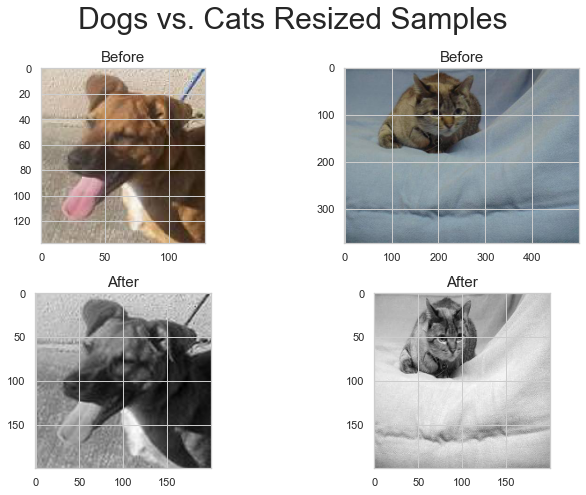

In [31]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 2, 1)
image = cv2.imread(img1_before)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Before', size=15)
fig.add_subplot(2, 2, 3)
plt.imshow(img1_after, cmap='gray')
plt.title('After', size=15)
fig.add_subplot(2, 2, 2)
image = cv2.imread(img2_before)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Before', size=15)
fig.add_subplot(2, 2, 4)
plt.imshow(img2_after, cmap='gray')
plt.title('After', size=15)
fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
plt.tight_layout()
plt.show()

In [32]:
# std_scl = StandardScaler()
# X_train_gray_scaled = std_scl.fit_transform(X_train_gray)
# joblib.dump(X_train_gray_scaled, 'dogs-vs-cats/X_train_gray_scaled' + '.z', compress=3)
# joblib.dump(std_scl, 'dogs-vs-cats/std_scl1.pkl')

In [33]:
X_train_gray_scaled = joblib.load(r'dogs-vs-cats/X_train_gray_scaled.z')

In [34]:
# pca = PCA(svd_solver='randomized', random_state=42)
# pca.fit(X_train_gray_scaled)
# joblib.dump(pca, "dogs-vs-cats/pca.pkl")

In [35]:
pca = joblib.load(r"dogs-vs-cats/pca.pkl")

In [36]:
# cumulative sum (increasing by sequential addition) of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

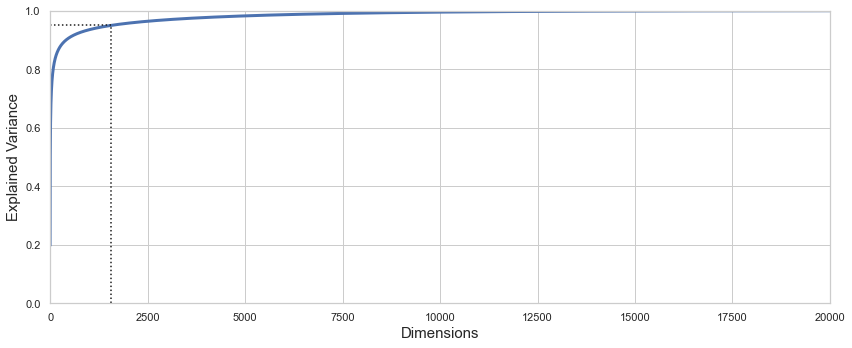

In [37]:
plt.figure(figsize=(12,5))
plt.axis([0, 20000, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.tight_layout()
plt.show()

In [38]:
d

1575

> We can preserve 95% of the variance with just 1575 features, drastically
> better than the original 40,000 dimensions!

In [39]:
# pca = PCA(n_components=d, svd_solver="randomized", random_state=42)
# pca.fit(X_train_gray_scaled)
# joblib.dump(pca, "dogs-vs-cats/pca2.pkl")

In [40]:
pca = joblib.load(r"dogs-vs-cats/pca2.pkl")

In [41]:
X_reduced = pca.transform(X_train_gray_scaled)

In [42]:
X_reduced.shape

(20000, 1575)

In [43]:
from sklearn.manifold import TSNE

In [44]:
tsne30 = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_reduced_tsne30 = tsne30.fit_transform(X_reduced, y_train_gray)
joblib.dump(X_reduced_tsne30, "dogs-vs-cats/X_reduced_tsne30.pkl")

tsne50 = TSNE(n_components=2, perplexity=50, random_state=42, n_jobs=-1)
X_reduced_tsne50 = tsne50.fit_transform(X_reduced, y_train_gray)
joblib.dump(X_reduced_tsne50, "dogs-vs-cats/X_reduced_tsne50.pkl")

['dogs-vs-cats/X_reduced_tsne50.pkl']

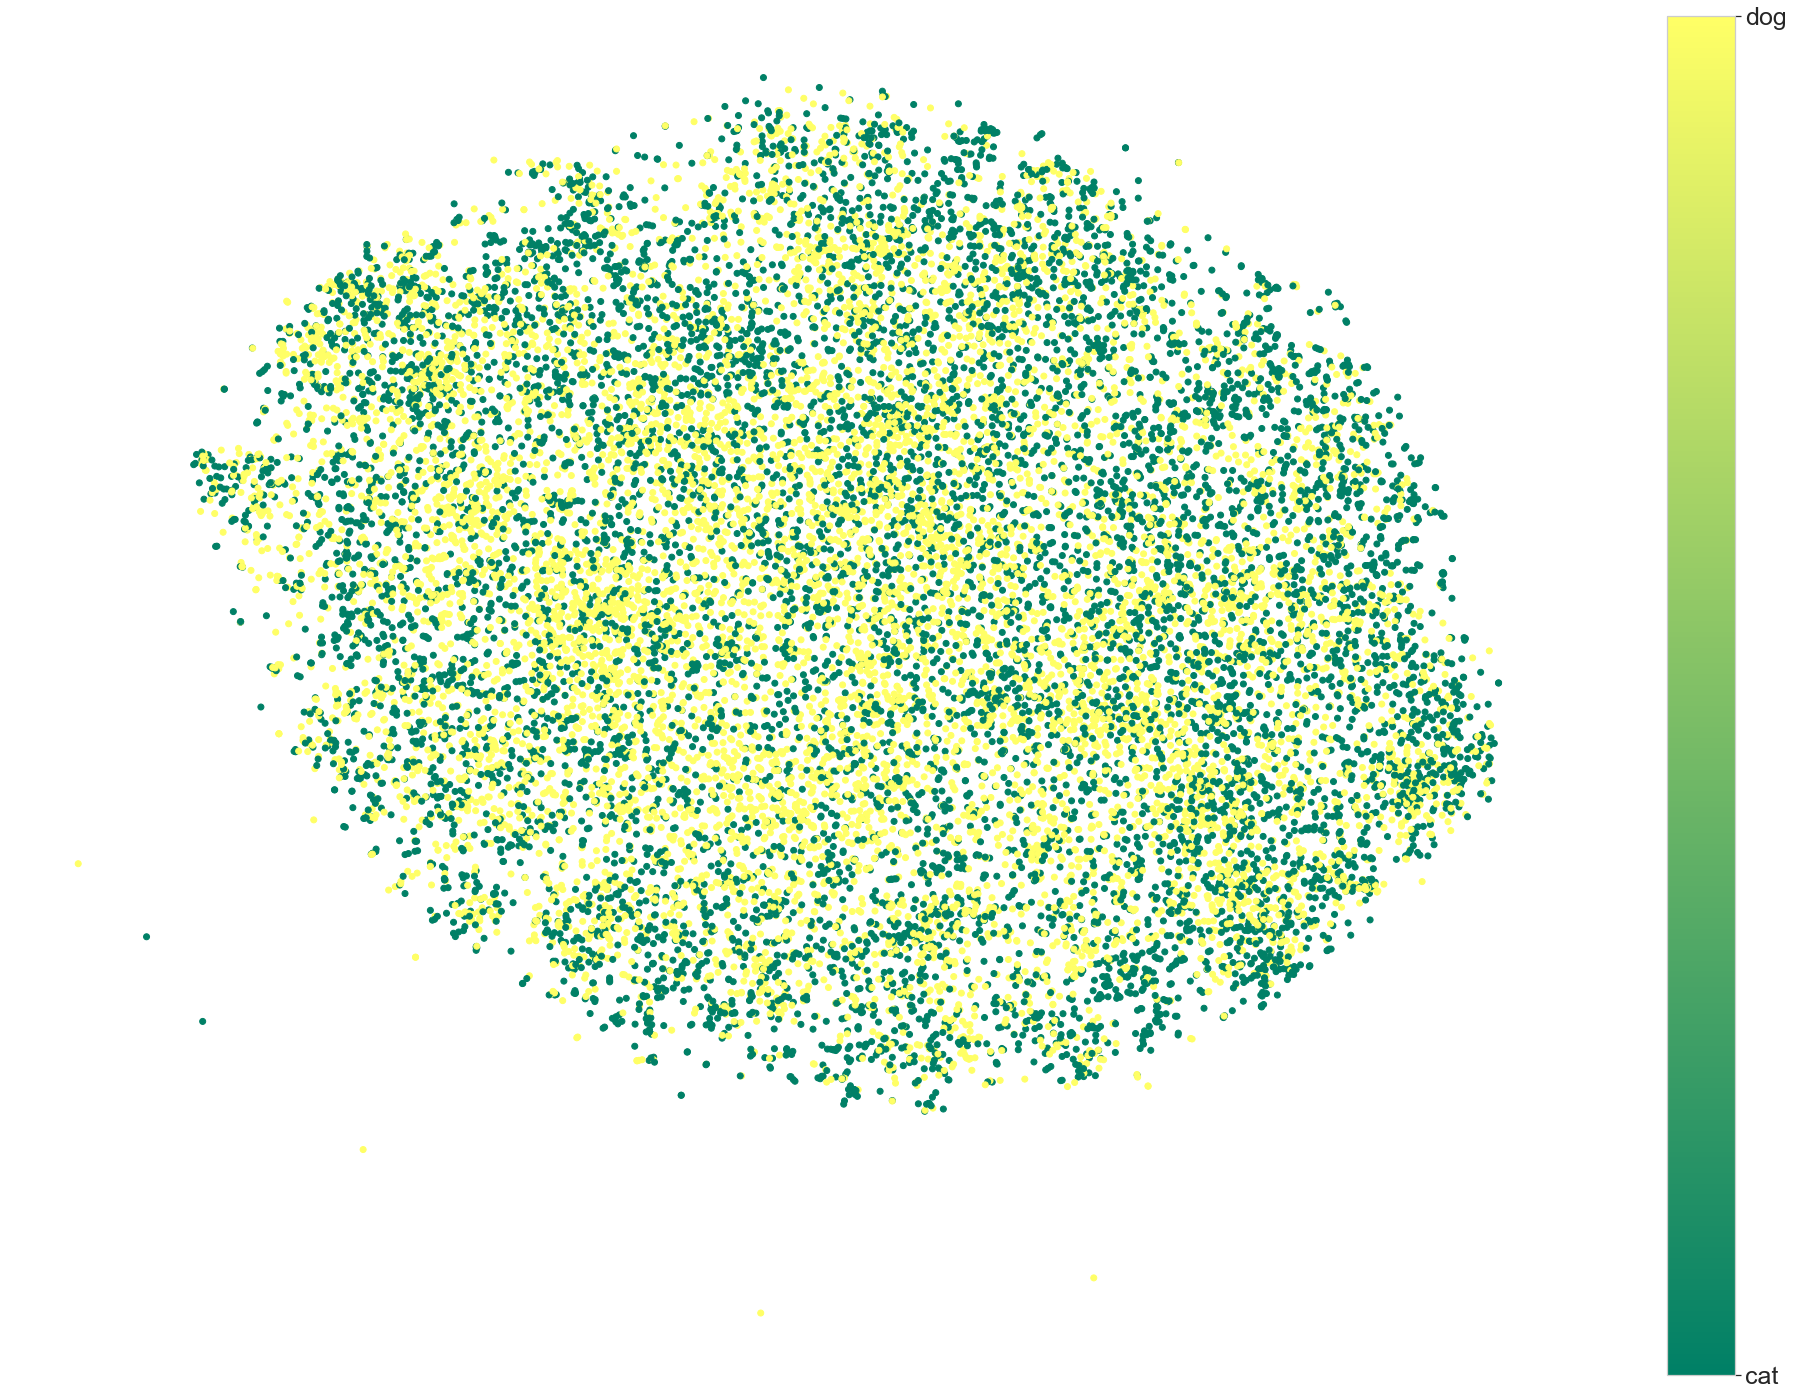

In [86]:
plt.figure(figsize=(35,25))
plt.scatter(X_reduced_tsne30[:, 0], X_reduced_tsne30[:, 1], c=y_train_gray, cmap='summer')
plt.axis('off')
cb = plt.colorbar(ticks=range(2))
cb.ax.set_yticklabels(['cat', 'dog'], size=25)
plt.show()

In [91]:
silhouette_scores = []
for i in range(2,21):
    print("Starting iteration {}".format(i-1))
    kmeans = KMeans(n_clusters= i, random_state=42)
    kmeans.fit(X_reduced)
    silhouette_scores.append(metrics.silhouette_score(X_reduced, kmeans.labels_))

Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 10
Starting iteration 11
Starting iteration 12
Starting iteration 13
Starting iteration 14
Starting iteration 15
Starting iteration 16
Starting iteration 17
Starting iteration 18
Starting iteration 19


In [95]:
joblib.dump(silhouette_scores, "dogs-vs-cats/silhouette_scores.pkl")

['dogs-vs-cats/silhouette_scores.pkl']

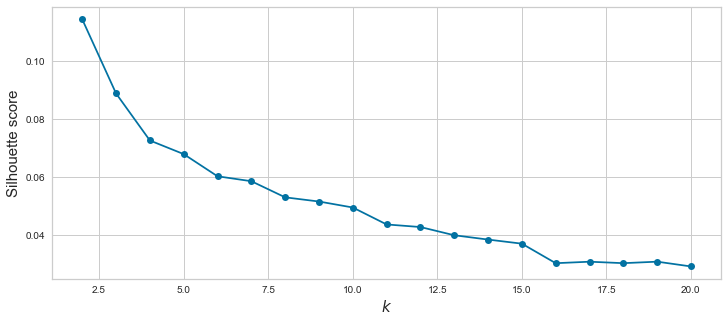

In [100]:
plt.figure(figsize=(12,5))
plt.plot(range(2,21), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=15)
plt.ylabel("Silhouette score", fontsize=15)
plt.show()

> Observations:
* When looking at the t-SNE plot, the classes mix in one big blob.
* The silhouette score for K-means is very low from the start (2 clusters) and drops as the number of
clusters increases.
* All silhouette scores are close to 0, which means that the instances are close to the cluster boundaries.
>
> Given these observations, it is clear that the images can't be clustered.

> PCA should definitely be used for pre-processing the data.
> Since there are still many dimensions, trying another dimensionality reduction algorithm on the
> transformed data should be considered.

# 3. Data Cleaning

In [ ]:
# clean copy of the training set
X_train = X_train_gray.copy()
y_train = y_train_gray.copy()

In [ ]:
# create transformation pipeline

full_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=d, svd_solver='randomized', random_state=42))
])

# 4. Training and Evaluating Models

------

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, n_jobs=-1)

log_reg.fit(X_train_gray, y_train.ravel())

predictions = log_reg.predict(X_train_gray)

In [7]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))

display_evaluation(y_train, predictions)

log_reg_2 = LogisticRegression(random_state=42, n_jobs=-1)
log_reg_2.fit(X_train_scaled, y_train.ravel())

In [ ]:
log_reg_cv = cross_val_score(log_reg, X_train_scaled, y_train.flatten(), n_jobs=-1, cv=5, scoring='accuracy')

In [ ]:
# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [ ]:
display_scores(log_reg_cv)

-------------------------

def read_resize_img(file_path, color):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)

def prep_data(images, color):
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file, color)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y, path

def load_data(img_dir, n_rows, n_cols, color):
    global ROWS, COLUMNS, CHANNELS
    ROWS = n_rows
    COLUMNS = n_cols
    if color:
        CHANNELS = 3
    else:
        CHANNELS = 1
    X, y, path = prep_data(img_dir, color)
    print("Converting to DataFrame")
    # create a DataFrame including a column for file path and labels
    df = pd.concat([pd.DataFrame(path, columns=['path']), pd.DataFrame(y, columns=['label']), pd.DataFrame(X)], axis=1)
    return df

df = load_data(images, n_rows=200, n_cols=200, color=True)

df.head()

In [ ]:
# check if all values are in DataFrame, merely a precaution after this data processing
# np.isnan checks if the element is is not a number
# df.values returns a numpy array containing the data without index or column names
# (like X shown above with an additional value in each row for the label)
# sum() returns the absolute amount missing
# np.isnan(df.values).sum()
df.isna().sum().sum()

In [ ]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

> Observations:
>> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
>> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
>> To validate my assumptions I counted the values for each class.
>> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
>> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
>> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
>> The random_state parameter ensures that the generated shuffled split is the same each time.
>

In [ ]:
df2

In [103]:
df['path'][0]

'dogs-vs-cats\\train/cat.0.jpg'

In [227]:
img = cv2.imread(df['path'][3], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_vec = img.reshape(-1, 3)
img_vec = np.float32(img_vec)

In [228]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42).fit(img_vec)

In [229]:
seg_img = kmeans.cluster_centers_[kmeans.labels_]
seg_img = seg_img.reshape(img.shape)
seg_img = seg_img.astype('uint8')

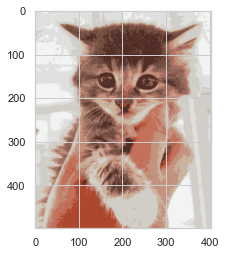

In [230]:
plt.imshow(seg_img)

> #### Resources:
> 1. Dogs vs. Cats Dataset <a href="https://www.kaggle.com/c/dogs-vs-cats"
> title="Kaggle">link</a>
> 2. Loading Data Tutorial <a href="https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-1-a347194e55b1"
> title="medium">link</a>